In [1]:
# ==================== 第1段: 导入库和数据准备 ====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize
from tabpfn_extensions import TabPFNClassifier
from tabpfn_extensions.rf_pfn import RandomForestTabPFNClassifier
import xgboost as xgb
import shap
import time
from collections import defaultdict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score, precision_score

# 新增导入：内存和模型大小监控
import psutil
import pickle
import sys
import gc
import threading
import os

# GPU监控（如果有GPU）
try:
    import GPUtil
    GPU_AVAILABLE = True
except ImportError:
    try:
        import nvidia_ml_py3 as nvml
        nvml.nvmlInit()
        GPU_AVAILABLE = True
    except ImportError:
        GPU_AVAILABLE = False
        print("GPU监控库未安装，将跳过GPU内存监控")

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

class PerformanceMonitor:
    """性能监控类"""
    def __init__(self):
        self.cpu_memory_usage = []
        self.gpu_memory_usage = []
        self.monitoring = False
        self.monitor_thread = None
        
    def start_monitoring(self):
        """开始监控"""
        self.monitoring = True
        self.cpu_memory_usage = []
        self.gpu_memory_usage = []
        self.monitor_thread = threading.Thread(target=self._monitor)
        self.monitor_thread.start()
        
    def stop_monitoring(self):
        """停止监控"""
        self.monitoring = False
        if self.monitor_thread:
            self.monitor_thread.join()
            
    def _monitor(self):
        """监控线程"""
        while self.monitoring:
            # CPU内存监控
            process = psutil.Process(os.getpid())
            cpu_mem = process.memory_info().rss / 1024 / 1024  # MB
            self.cpu_memory_usage.append(cpu_mem)
            
            # GPU内存监控
            if GPU_AVAILABLE:
                try:
                    if 'GPUtil' in sys.modules:
                        gpus = GPUtil.getGPUs()
                        if gpus:
                            gpu_mem = gpus[0].memoryUsed
                            self.gpu_memory_usage.append(gpu_mem)
                    else:
                        handle = nvml.nvmlDeviceGetHandleByIndex(0)
                        info = nvml.nvmlDeviceGetMemoryInfo(handle)
                        gpu_mem = info.used / 1024 / 1024  # MB
                        self.gpu_memory_usage.append(gpu_mem)
                except:
                    self.gpu_memory_usage.append(0)
            else:
                self.gpu_memory_usage.append(0)
                
            time.sleep(0.1)  # 每0.1秒监控一次
            
    def get_peak_memory(self):
        """获取峰值内存使用"""
        cpu_peak = max(self.cpu_memory_usage) if self.cpu_memory_usage else 0
        gpu_peak = max(self.gpu_memory_usage) if self.gpu_memory_usage else 0
        return cpu_peak, gpu_peak

def get_model_size(model):
    """获取模型大小（MB）"""
    try:
        # 序列化模型到内存
        model_bytes = pickle.dumps(model)
        size_mb = len(model_bytes) / 1024 / 1024
        return size_mb
    except:
        return 0

def prepare_data():
    """数据准备函数"""
    # 读取数据
    df = pd.read_csv('resampled_data.csv')
    
    X = df.drop(columns=['category','attack', 'category', 'subcategory','stime','pkSeqID'])
    y = df.loc[:, 'category']
    
    # 对因变量进行编码
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # 分割数据
    X_train_full, X_test_full, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"训练集大小: {X_train_full.shape}")
    print(f"测试集大小: {X_test_full.shape}")
    print(f"特征总数: {X.shape[1]}")
    
    return X, y, X_train_full, X_test_full, y_train, y_test, le

# 执行数据准备
X, y, X_train_full, X_test_full, y_train, y_test, le = prepare_data()
results = defaultdict(dict)


训练集大小: (40427, 67)
测试集大小: (10107, 67)
特征总数: 67


In [2]:

# %%
# ==================== 第2段: 特征选择函数定义和执行 ====================
def lasso_feature_selection(X_train, y_train, alpha_range=None):
    """Lasso特征选择"""
    if alpha_range is None:
        alpha_range = np.logspace(-4, 0, 50)
        
    # 标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Lasso CV
    lasso_cv = LassoCV(alphas=alpha_range, cv=5, random_state=42)
    lasso_cv.fit(X_scaled, y_train)
    
    # 获取最佳模型
    best_lasso = Lasso(alpha=0.026203985288583486, random_state=42)
    best_lasso.fit(X_scaled, y_train)
    
    # 选择特征
    lasso_importance = np.abs(best_lasso.coef_)
    selected_features = X_train.columns[lasso_importance > 0]
    
    print(f"Lasso选择的特征数: {len(selected_features)}")
    return selected_features, scaler, best_lasso

def rfe_feature_selection(X_train, y_train, n_features=30):
    """RFE特征选择"""
    # 标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # RFE
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    n_features_to_select = min(n_features, len(X_train.columns))
    
    rfe = RFE(estimator=rf, n_features_to_select=n_features_to_select, step=1)
    rfe.fit(X_scaled, y_train)
    
    selected_features = X_train.columns[rfe.support_]
    
    print(f"RFE选择的特征数: {len(selected_features)}")
    return selected_features, scaler, rfe

# 执行特征选择
print("=== 特征选择 ===")
lasso_features, lasso_scaler, lasso_model = lasso_feature_selection(X_train_full, y_train)
rfe_features, rfe_scaler, rfe_model = rfe_feature_selection(X_train_full, y_train)

# 计算特征交集
common_features = list(set(lasso_features).intersection(set(rfe_features)))
print(f"特征交集数: {len(common_features)}")

if len(common_features) == 0:
    print("警告: 没有交集特征，使用Lasso特征")
    final_features = lasso_features
else:
    final_features = common_features


=== 特征选择 ===


c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.969150470133172, tolerance: 3.940216431155497
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.04467840965754, tolerance: 3.940216431155497
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301.5289415662601, tolerance: 3.940216431155497
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-pac

Lasso选择的特征数: 15
RFE选择的特征数: 30
特征交集数: 7


In [3]:
# ==================== 第3段: 增强的模型评估函数 ====================
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """增强的模型评估函数"""
    print(f"\n评估模型: {model_name}")
    
    # 初始化性能监控器
    monitor = PerformanceMonitor()
    
    # 清理内存
    gc.collect()
    
    # 训练阶段监控
    monitor.start_monitoring()
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    monitor.stop_monitoring()
    
    # 获取训练阶段的峰值内存
    train_cpu_peak, train_gpu_peak = monitor.get_peak_memory()
    
    # 预测阶段监控
    monitor = PerformanceMonitor()  # 重新初始化
    gc.collect()
    
    monitor.start_monitoring()
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    monitor.stop_monitoring()
    
    # 获取预测阶段的峰值内存
    predict_cpu_peak, predict_gpu_peak = monitor.get_peak_memory()
    
    # 获取模型大小
    model_size = get_model_size(model)
    
    # 计算指标
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    macro_precision = precision_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # 计算AUC (多分类)
    try:
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)
        elif hasattr(model, 'decision_function'):
            y_prob = model.decision_function(X_test)
        else:
            y_prob = None
            
        if y_prob is not None:
            # 二值化标签
            y_test_bin = label_binarize(y_test, classes=np.unique(y))
            n_classes = y_test_bin.shape[1]
            
            # 计算每类AUC
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            
            mean_auc = np.mean(list(roc_auc.values()))
        else:
            mean_auc = None
    except:
        mean_auc = None
    
    # 打印结果
    print(f"准确率: {accuracy:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"特征数: {X_train.shape[1]}")
    if mean_auc:
        print(f"平均AUC: {mean_auc:.4f}")
    print(f"训练时间: {train_time:.2f}秒")
    print(f"推理时间: {predict_time:.4f}秒")
    print(f"模型大小: {model_size:.2f}MB")
    print(f"训练峰值CPU内存: {train_cpu_peak:.2f}MB")
    print(f"推理峰值CPU内存: {predict_cpu_peak:.2f}MB")
    if GPU_AVAILABLE:
        print(f"训练峰值GPU内存: {train_gpu_peak:.2f}MB")
        print(f"推理峰值GPU内存: {predict_gpu_peak:.2f}MB")
    
    return {
        'model': model,
        'accuracy': accuracy,
        'macro_accuracy': macro_precision,
        'macro_precision': macro_precision,
        'macro_f1': macro_f1,
        'confusion_matrix': conf_matrix,
        'train_time': train_time,
        'predict_time': predict_time,
        'inference_time': predict_time,  # 推理时间
        'model_size_mb': model_size,
        'train_cpu_memory_peak': train_cpu_peak,
        'predict_cpu_memory_peak': predict_cpu_peak,
        'train_gpu_memory_peak': train_gpu_peak if GPU_AVAILABLE else 0,
        'predict_gpu_memory_peak': predict_gpu_peak if GPU_AVAILABLE else 0,
        'mean_auc': mean_auc,
        'predictions': y_pred,
        'n_features': X_train.shape[1]
    }

print("增强的模型评估函数已定义")

增强的模型评估函数已定义


In [4]:
# %%
# ==================== 第4段-第8段: 实验组函数（保持原有结构）====================
def run_experiment_group_1():
    """Group 1: 完整模型 (Lasso + RFE + RF-TabPFN)"""
    print("\n=== Group 1: 完整模型 (Lasso + RFE + RF-TabPFN) ===")
    
    X_train_selected = X_train_full[final_features]
    X_test_selected = X_test_full[final_features]
    
    clf_base = TabPFNClassifier(
        ignore_pretraining_limits=True,
        inference_config={"SUBSAMPLE_SAMPLES": 10000}
    )
    
    tabpfn_tree_clf = RandomForestTabPFNClassifier(
        tabpfn=clf_base,
        verbose=0,
        max_predict_time=60
    )
    
    result = evaluate_model(
        tabpfn_tree_clf, X_train_selected, X_test_selected, 
        y_train, y_test, "Group1_Full"
    )
    
    results['group1'] = result
    results['group1']['features'] = final_features
    return result

def run_experiment_group_2():
    """Group 2: 无特征筛选 (原始特征 + RF-TabPFN)"""
    print("\n=== Group 2: 无特征筛选 (原始特征 + RF-TabPFN) ===")
    
    X_train_all = X_train_full
    X_test_all = X_test_full
    
    clf_base = TabPFNClassifier(
        ignore_pretraining_limits=True,
        inference_config={"SUBSAMPLE_SAMPLES": 10000}
    )
    
    tabpfn_tree_clf = RandomForestTabPFNClassifier(
        tabpfn=clf_base,
        verbose=0,
        max_predict_time=60
    )
    
    result = evaluate_model(
        tabpfn_tree_clf, X_train_all, X_test_all,
        y_train, y_test, "Group2_NoSelection"
    )
    
    results['group2'] = result
    results['group2']['features'] = list(X_train_full.columns)
    return result

def run_experiment_group_3():
    """Group 3: 仅Lasso (Lasso筛选 + RF-TabPFN)"""
    print("\n=== Group 3: 仅Lasso (Lasso筛选 + RF-TabPFN) ===")
    
    X_train_lasso = X_train_full[lasso_features]
    X_test_lasso = X_test_full[lasso_features]
    
    clf_base = TabPFNClassifier(
        ignore_pretraining_limits=True,
        inference_config={"SUBSAMPLE_SAMPLES": 10000}
    )
    
    tabpfn_tree_clf = RandomForestTabPFNClassifier(
        tabpfn=clf_base,
        verbose=0,
        max_predict_time=60
    )
    
    result = evaluate_model(
        tabpfn_tree_clf, X_train_lasso, X_test_lasso,
        y_train, y_test, "Group3_LassoOnly"
    )
    
    results['group3'] = result
    results['group3']['features'] = list(lasso_features)
    return result

def run_experiment_group_4():
    """Group 4: 仅RFE (RFE筛选 + RF-TabPFN)"""
    print("\n=== Group 4: 仅RFE (RFE筛选 + RF-TabPFN) ===")
    
    X_train_rfe = X_train_full[rfe_features]
    X_test_rfe = X_test_full[rfe_features]
    
    clf_base = TabPFNClassifier(
        ignore_pretraining_limits=True,
        inference_config={"SUBSAMPLE_SAMPLES": 10000}
    )
    
    tabpfn_tree_clf = RandomForestTabPFNClassifier(
        tabpfn=clf_base,
        verbose=0,
        max_predict_time=60
    )
    
    result = evaluate_model(
        tabpfn_tree_clf, X_train_rfe, X_test_rfe,
        y_train, y_test, "Group4_RFEOnly"
    )
    
    results['group4'] = result
    results['group4']['features'] = list(rfe_features)
    return result

def run_experiment_group_5():
    """Group 5: 单模型 (Lasso + RFE + 纯TabPFN)"""
    print("\n=== Group 5: 单模型 (Lasso + RFE + 纯TabPFN) ===")
    
    X_train_selected = X_train_full[final_features]
    X_test_selected = X_test_full[final_features]
    
    tabpfn_clf = TabPFNClassifier(
        ignore_pretraining_limits=True,
        n_estimators=64,
        inference_config={"SUBSAMPLE_SAMPLES": 12000}
    )
    
    result = evaluate_model(
        tabpfn_clf, X_train_selected, X_test_selected,
        y_train, y_test, "Group5_PureTabPFN"
    )
    
    results['group5'] = result
    results['group5']['features'] = final_features
    return result

def run_experiment_group_6():
    """Group 6: Random Forest模型 (Lasso + RFE + Random Forest)"""
    print("\n=== Group 6: Random Forest模型 (Lasso + RFE + Random Forest) ===")
    
    X_train_selected = X_train_full[final_features]
    X_test_selected = X_test_full[final_features]
    
    rf_clf = RandomForestClassifier(
        n_estimators=10, 
        max_depth=2, 
        min_samples_split=10, 
        random_state=42
    )
    
    result = evaluate_model(
        rf_clf, X_train_selected, X_test_selected,
        y_train, y_test, "Group6_RandomForest"
    )
    
    results['group6'] = result
    results['group6']['features'] = final_features
    return result

# 执行所有实验组
print("开始执行所有实验组...")
group1_result = run_experiment_group_1()
group2_result = run_experiment_group_2()
group3_result = run_experiment_group_3()
group4_result = run_experiment_group_4()
group5_result = run_experiment_group_5()
group6_result = run_experiment_group_6()

# %%

开始执行所有实验组...

=== Group 1: 完整模型 (Lasso + RFE + RF-TabPFN) ===

评估模型: Group1_Full


c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 32341 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 32341 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater th

准确率: 0.9998
Macro F1: 0.9975
Macro Precision: 0.9975
特征数: 7
平均AUC: 1.0000
训练时间: 4.07秒
推理时间: 62.1389秒
模型大小: 848.60MB
训练峰值CPU内存: 1351.85MB
推理峰值CPU内存: 2224.57MB
训练峰值GPU内存: 1531.00MB
推理峰值GPU内存: 3488.00MB

=== Group 2: 无特征筛选 (原始特征 + RF-TabPFN) ===

评估模型: Group2_NoSelection


c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 32341 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


准确率: 0.9998
Macro F1: 0.9987
Macro Precision: 0.9976
特征数: 67
平均AUC: 1.0000
训练时间: 11.78秒
推理时间: 111.3363秒
模型大小: 6436.65MB
训练峰值CPU内存: 8372.40MB
推理峰值CPU内存: 9458.57MB
训练峰值GPU内存: 3421.00MB
推理峰值GPU内存: 5895.00MB

=== Group 3: 仅Lasso (Lasso筛选 + RF-TabPFN) ===

评估模型: Group3_LassoOnly


c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 32341 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 32341 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater th

准确率: 0.9997
Macro F1: 0.9975
Macro Precision: 0.9975
特征数: 15
平均AUC: 1.0000
训练时间: 4.42秒
推理时间: 69.0975秒
模型大小: 1590.94MB
训练峰值CPU内存: 2845.31MB
推理峰值CPU内存: 3555.30MB
训练峰值GPU内存: 5885.00MB
推理峰值GPU内存: 5946.00MB

=== Group 4: 仅RFE (RFE筛选 + RF-TabPFN) ===

评估模型: Group4_RFEOnly


c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 32341 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 32341 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater th

准确率: 0.9996
Macro F1: 0.9986
Macro Precision: 0.9997
特征数: 30
平均AUC: 1.0000
训练时间: 8.13秒
推理时间: 111.5024秒
模型大小: 2991.24MB
训练峰值CPU内存: 3697.22MB
推理峰值CPU内存: 5643.27MB
训练峰值GPU内存: 5829.00MB
推理峰值GPU内存: 5829.00MB

=== Group 5: 单模型 (Lasso + RFE + 纯TabPFN) ===

评估模型: Group5_PureTabPFN


c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


准确率: 0.9998
Macro F1: 0.9976
Macro Precision: 0.9954
特征数: 7
平均AUC: 1.0000
训练时间: 2.84秒
推理时间: 103.1436秒
模型大小: 111.99MB
训练峰值CPU内存: 3537.10MB
推理峰值CPU内存: 3537.65MB
训练峰值GPU内存: 5744.00MB
推理峰值GPU内存: 5855.00MB

=== Group 6: Random Forest模型 (Lasso + RFE + Random Forest) ===

评估模型: Group6_RandomForest
准确率: 0.9848
Macro F1: 0.5922
Macro Precision: 0.5901
特征数: 7
平均AUC: 0.9954
训练时间: 0.14秒
推理时间: 0.0105秒
模型大小: 0.01MB
训练峰值CPU内存: 3562.31MB
推理峰值CPU内存: 3562.79MB
训练峰值GPU内存: 5820.00MB
推理峰值GPU内存: 5820.00MB


c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


THREE MODELS COMPLETE PERFORMANCE ANALYSIS
Models: Lasso-RFE RF-TabPFN, Lasso-RFE Random Forest, Lasso-RFE TabPFN

=== Plotting Time Metrics for Three Selected Models (1x2 Layout) ===


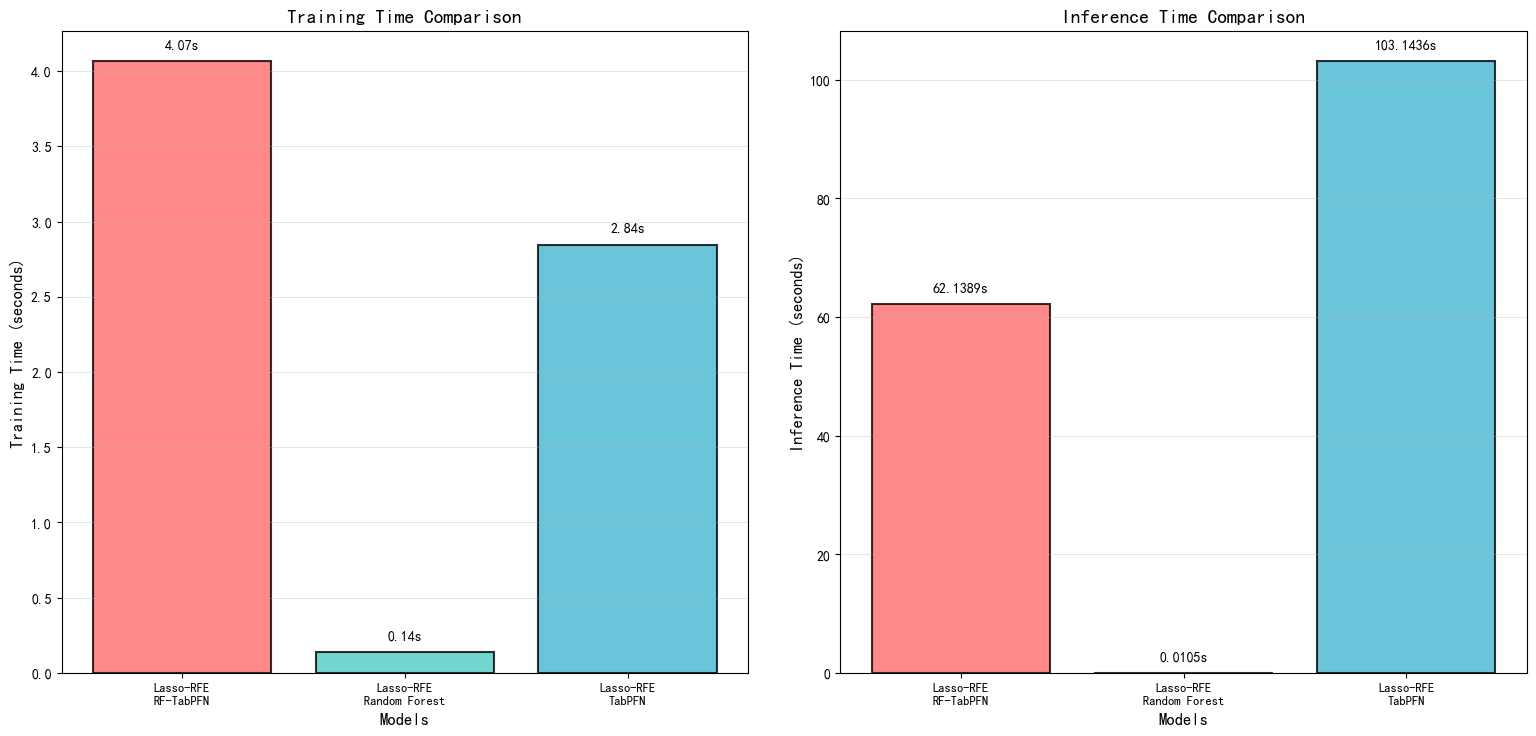

Three models time metrics saved as 'Three_Models_Time_Metrics.svg'

=== Plotting Memory Metrics for Three Selected Models (1x2 Layout) ===


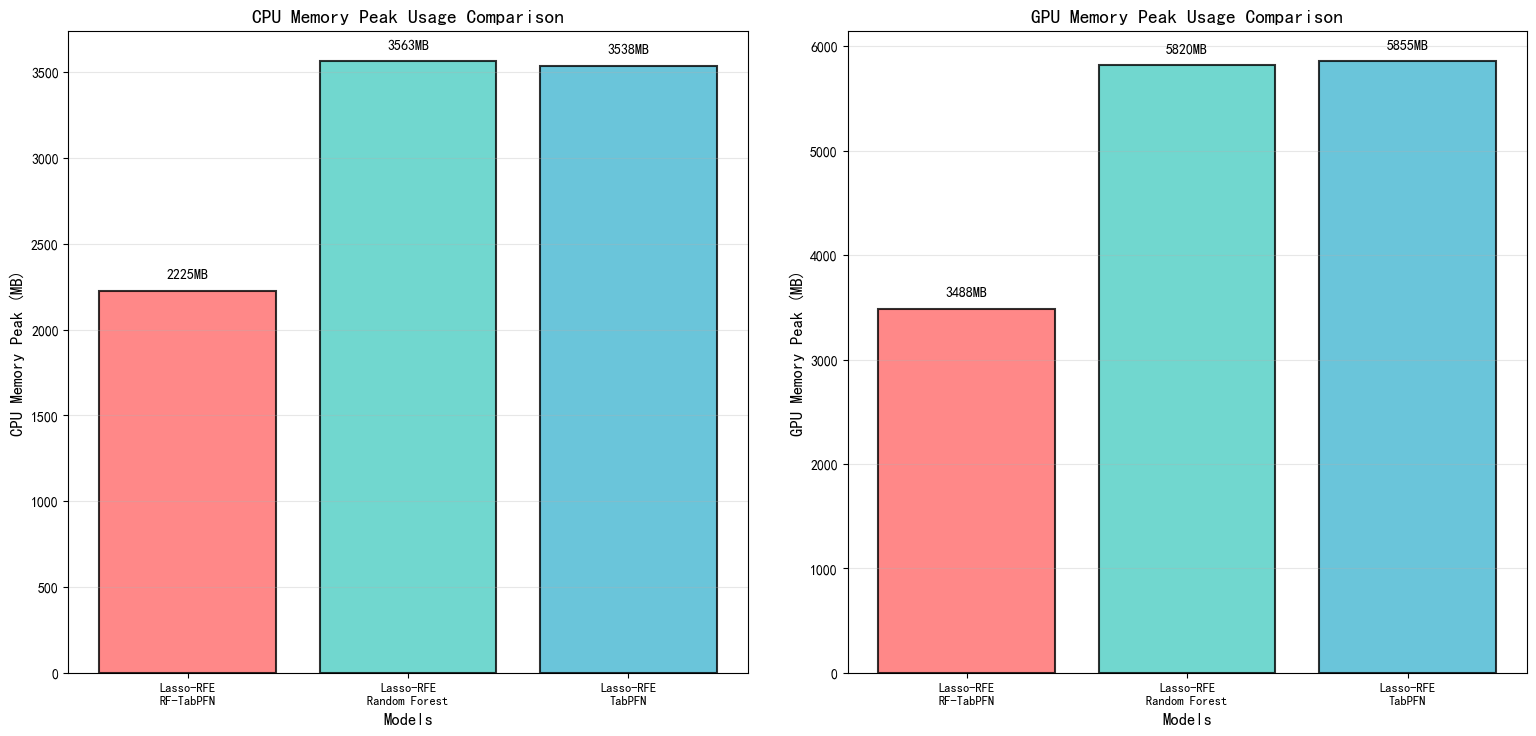

Three models memory metrics saved as 'Three_Models_Memory_Metrics.svg'

=== Plotting Per Sample Time Metrics for Three Selected Models (1x2 Layout) ===


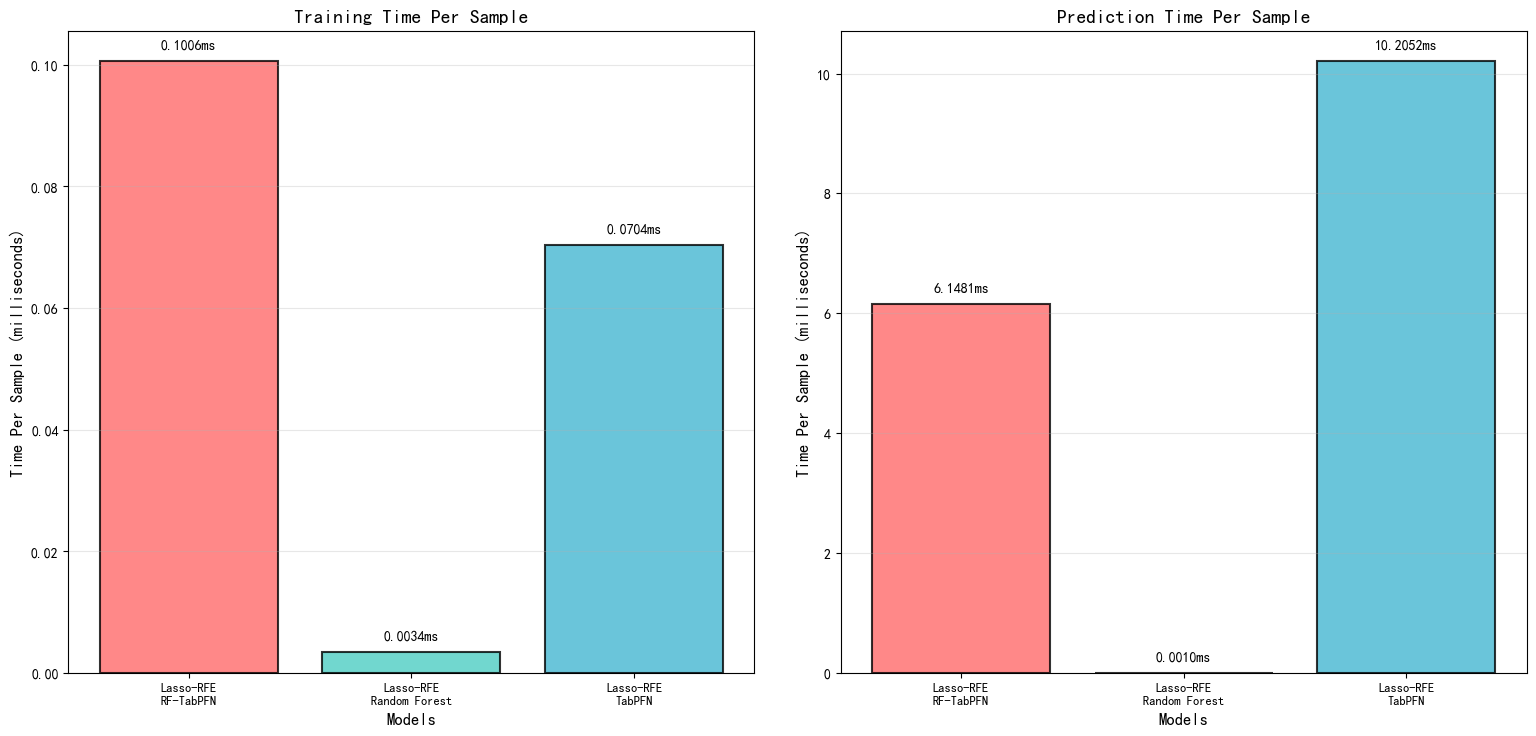

Three models per sample metrics saved as 'Three_Models_Per_Sample_Metrics.svg'

=== Per Sample Time Analysis ===
Training samples: 40427
Testing samples: 10107
--------------------------------------------------------------------------------
Lasso-RFE RF-TabPFN:
  Training time per sample: 0.1006 ms
  Prediction time per sample: 6.1481 ms
  Total training time: 4.0657 seconds
  Total inference time: 62.1389 seconds
----------------------------------------
Lasso-RFE Random Forest:
  Training time per sample: 0.0034 ms
  Prediction time per sample: 0.0010 ms
  Total training time: 0.1384 seconds
  Total inference time: 0.0105 seconds
----------------------------------------
Lasso-RFE TabPFN:
  Training time per sample: 0.0704 ms
  Prediction time per sample: 10.2052 ms
  Total training time: 2.8441 seconds
  Total inference time: 103.1436 seconds
----------------------------------------

=== Three Models Performance Summary ===
-------------------------------------------------------------

In [5]:
def plot_three_models_time_metrics():
    """绘制三个特定模型的时间指标 - 1x2布局（训练时间 + 推理时间）"""
    print("\n=== Plotting Time Metrics for Three Selected Models (1x2 Layout) ===")
    
    # 只选择这三个模型
    selected_groups = {
        'group1': 'Lasso-RFE\nRF-TabPFN',
        'group6': 'Lasso-RFE\nRandom Forest', 
        'group5': 'Lasso-RFE\nTabPFN'
    }
    
    # 准备数据
    groups = []
    train_times = []
    inference_times = []
    
    for group_key, group_name in selected_groups.items():
        if group_key in results:
            result = results[group_key]
            groups.append(group_name)
            train_times.append(result['train_time'])
            inference_times.append(result['inference_time'])
    
    # 创建1x2子图布局
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # 使用统一的颜色方案
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # 1. Training Time Comparison (左)
    bars1 = axes[0].bar(range(len(groups)), train_times, 
                       color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Training Time (seconds)', fontsize=12)
    axes[0].set_xlabel('Models', fontsize=12)
    axes[0].set_xticks(range(len(groups)))
    axes[0].set_xticklabels(groups, rotation=0, ha='center', fontsize=9)
    axes[0].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(train_times):
        axes[0].text(i, v + max(train_times)*0.02, f'{v:.2f}s', ha='center', fontweight='bold', fontsize=10)
    
    # 2. Inference Time Comparison (右)
    bars2 = axes[1].bar(range(len(groups)), inference_times, 
                       color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[1].set_title('Inference Time Comparison', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Inference Time (seconds)', fontsize=12)
    axes[1].set_xlabel('Models', fontsize=12)
    axes[1].set_xticks(range(len(groups)))
    axes[1].set_xticklabels(groups, rotation=0, ha='center', fontsize=9)
    axes[1].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(inference_times):
        axes[1].text(i, v + max(inference_times)*0.02, f'{v:.4f}s', ha='center', fontweight='bold', fontsize=10)
    
    plt.tight_layout(pad=3.0)
    plt.savefig('Three_Models_Time_Metrics.svg', format='svg', bbox_inches='tight', dpi=300)
    plt.show()
    print("Three models time metrics saved as 'Three_Models_Time_Metrics.svg'")


def plot_three_models_memory_metrics():
    """绘制三个特定模型的内存指标 - 1x2布局（CPU内存 + GPU内存）"""
    print("\n=== Plotting Memory Metrics for Three Selected Models (1x2 Layout) ===")
    
    # 只选择这三个模型
    selected_groups = {
        'group1': 'Lasso-RFE\nRF-TabPFN',
        'group6': 'Lasso-RFE\nRandom Forest', 
        'group5': 'Lasso-RFE\nTabPFN'
    }
    
    # 准备数据
    groups = []
    cpu_memory_usage = []
    gpu_memory_usage = []
    
    for group_key, group_name in selected_groups.items():
        if group_key in results:
            result = results[group_key]
            groups.append(group_name)
            cpu_memory_usage.append(max(result['train_cpu_memory_peak'], result['predict_cpu_memory_peak']))
            
            if GPU_AVAILABLE:
                gpu_memory_usage.append(max(result['train_gpu_memory_peak'], result['predict_gpu_memory_peak']))
            else:
                gpu_memory_usage.append(0)
    
    # 创建1x2子图布局
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # 使用统一的颜色方案
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # 1. CPU Memory Peak Usage Comparison (左)
    bars1 = axes[0].bar(range(len(groups)), cpu_memory_usage, 
                       color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[0].set_title('CPU Memory Peak Usage Comparison', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('CPU Memory Peak (MB)', fontsize=12)
    axes[0].set_xlabel('Models', fontsize=12)
    axes[0].set_xticks(range(len(groups)))
    axes[0].set_xticklabels(groups, rotation=0, ha='center', fontsize=9)
    axes[0].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(cpu_memory_usage):
        axes[0].text(i, v + max(cpu_memory_usage)*0.02, f'{v:.0f}MB', ha='center', fontweight='bold', fontsize=10)
    
    # 2. GPU Memory Peak Usage Comparison (右)
    if GPU_AVAILABLE and any(gpu_memory_usage):
        bars2 = axes[1].bar(range(len(groups)), gpu_memory_usage, 
                           color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[1].set_title('GPU Memory Peak Usage Comparison', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('GPU Memory Peak (MB)', fontsize=12)
        axes[1].set_xlabel('Models', fontsize=12)
        axes[1].set_xticks(range(len(groups)))
        axes[1].set_xticklabels(groups, rotation=0, ha='center', fontsize=9)
        axes[1].grid(True, alpha=0.3, axis='y')
        for i, v in enumerate(gpu_memory_usage):
            if v > 0:
                axes[1].text(i, v + max(gpu_memory_usage)*0.02, f'{v:.0f}MB', ha='center', fontweight='bold', fontsize=10)
    else:
        axes[1].text(0.5, 0.5, 'GPU Not Available', ha='center', va='center', 
                    transform=axes[1].transAxes, fontsize=16, fontweight='bold')
        axes[1].set_title('GPU Memory Peak Usage Comparison', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Models', fontsize=12)
        axes[1].set_ylabel('GPU Memory Peak (MB)', fontsize=12)
        axes[1].set_xticks(range(len(groups)))
        axes[1].set_xticklabels(groups, rotation=0, ha='center', fontsize=9)
    
    plt.tight_layout(pad=3.0)
    plt.savefig('Three_Models_Memory_Metrics.svg', format='svg', bbox_inches='tight', dpi=300)
    plt.show()
    print("Three models memory metrics saved as 'Three_Models_Memory_Metrics.svg'")


def plot_three_models_per_sample_metrics():
    """绘制三个特定模型的每样本时间指标 - 1x2布局（每样本训练时间 + 每样本预测时间）"""
    print("\n=== Plotting Per Sample Time Metrics for Three Selected Models (1x2 Layout) ===")
    
    # 只选择这三个模型
    selected_groups = {
        'group1': 'Lasso-RFE\nRF-TabPFN',
        'group6': 'Lasso-RFE\nRandom Forest', 
        'group5': 'Lasso-RFE\nTabPFN'
    }
    
    # 准备数据
    groups = []
    train_times_per_sample = []
    predict_times_per_sample = []
    
    # 获取样本数量
    train_sample_count = len(y_train) if 'y_train' in globals() else 1000
    test_sample_count = len(y_test) if 'y_test' in globals() else 200
    
    for group_key, group_name in selected_groups.items():
        if group_key in results:
            result = results[group_key]
            groups.append(group_name)
            
            # 计算每样本时间（毫秒）
            train_per_sample = result['train_time'] / train_sample_count * 1000
            predict_per_sample = result['inference_time'] / test_sample_count * 1000
            train_times_per_sample.append(train_per_sample)
            predict_times_per_sample.append(predict_per_sample)
    
    # 创建1x2子图布局
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # 使用统一的颜色方案
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # 1. Training Time Per Sample (左)
    bars1 = axes[0].bar(range(len(groups)), train_times_per_sample, 
                       color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[0].set_title('Training Time Per Sample', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Time Per Sample (milliseconds)', fontsize=12)
    axes[0].set_xlabel('Models', fontsize=12)
    axes[0].set_xticks(range(len(groups)))
    axes[0].set_xticklabels(groups, rotation=0, ha='center', fontsize=9)
    axes[0].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(train_times_per_sample):
        axes[0].text(i, v + max(train_times_per_sample)*0.02, f'{v:.4f}ms', ha='center', fontweight='bold', fontsize=10)
    
    # 2. Prediction Time Per Sample (右)
    bars2 = axes[1].bar(range(len(groups)), predict_times_per_sample, 
                       color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[1].set_title('Prediction Time Per Sample', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Time Per Sample (milliseconds)', fontsize=12)
    axes[1].set_xlabel('Models', fontsize=12)
    axes[1].set_xticks(range(len(groups)))
    axes[1].set_xticklabels(groups, rotation=0, ha='center', fontsize=9)
    axes[1].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(predict_times_per_sample):
        axes[1].text(i, v + max(predict_times_per_sample)*0.02, f'{v:.4f}ms', ha='center', fontweight='bold', fontsize=10)
    
    plt.tight_layout(pad=3.0)
    plt.savefig('Three_Models_Per_Sample_Metrics.svg', format='svg', bbox_inches='tight', dpi=300)
    plt.show()
    print("Three models per sample metrics saved as 'Three_Models_Per_Sample_Metrics.svg'")
    
    # 输出详细的每样本时间信息
    print("\n=== Per Sample Time Analysis ===")
    print(f"Training samples: {train_sample_count}")
    print(f"Testing samples: {test_sample_count}")
    print("-" * 80)
    
    for i, (group_key, group_name) in enumerate(selected_groups.items()):
        if group_key in results:
            result = results[group_key]
            print(f"{group_name.replace(chr(10), ' ')}:")
            print(f"  Training time per sample: {train_times_per_sample[i]:.4f} ms")
            print(f"  Prediction time per sample: {predict_times_per_sample[i]:.4f} ms")
            print(f"  Total training time: {result['train_time']:.4f} seconds")
            print(f"  Total inference time: {result['inference_time']:.4f} seconds")
            print("-" * 40)


def create_three_models_summary_table():
    """创建三个模型的汇总对比表"""
    print("\n=== Three Models Performance Summary ===")
    
    selected_groups = {
        'group1': 'Lasso-RFE RF-TabPFN',
        'group6': 'Lasso-RFE Random Forest',
        'group5': 'Lasso-RFE TabPFN'
    }
    
    # 获取样本数量
    train_sample_count = len(y_train) if 'y_train' in globals() else 1000
    test_sample_count = len(y_test) if 'y_test' in globals() else 200
    
    print("-" * 130)
    print(f"{'Model':<25} {'Precision':<10} {'Train/Sample(ms)':<17} {'Predict/Sample(ms)':<19} {'Total Train(s)':<15} {'Total Predict(s)':<17}")
    print("-" * 130)
    
    for group_key, group_name in selected_groups.items():
        if group_key in results:
            result = results[group_key]
            precision = result['macro_precision']
            train_per_sample = result['train_time'] / train_sample_count * 1000
            predict_per_sample = result['inference_time'] / test_sample_count * 1000
            
            print(f"{group_name:<25} {precision:<10.4f} {train_per_sample:<17.4f} {predict_per_sample:<19.4f} {result['train_time']:<15.4f} {result['inference_time']:<17.4f}")
    
    print("-" * 130)


def run_three_models_complete_analysis():
    """运行三个模型的完整分析 - 生成三个独立的1x2图表"""
    print("="*80)
    print("THREE MODELS COMPLETE PERFORMANCE ANALYSIS")
    print("Models: Lasso-RFE RF-TabPFN, Lasso-RFE Random Forest, Lasso-RFE TabPFN")
    print("="*80)
    
    # 1. 绘制时间指标 (训练时间 + 推理时间)
    plot_three_models_time_metrics()
    
    # 2. 绘制内存指标 (CPU内存 + GPU内存)
    plot_three_models_memory_metrics()
    
    # 3. 绘制每样本时间指标 (每样本训练时间 + 每样本预测时间)
    plot_three_models_per_sample_metrics()
    
    # 4. 创建汇总表
    create_three_models_summary_table()
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)
    print("Generated files:")
    print("1. Three_Models_Time_Metrics.svg - Time comparison (Training Time + Inference Time)")
    print("2. Three_Models_Memory_Metrics.svg - Memory comparison (CPU Memory + GPU Memory)")
    print("3. Three_Models_Per_Sample_Metrics.svg - Per sample time comparison (Train/Sample + Predict/Sample)")
    print("\nEach file contains a 1x2 layout with two related metrics for easy comparison.")


# 执行完整分析
run_three_models_complete_analysis()